In [ ]:
%%capture
!pip install osmnx pyrosm
!apt-get update -qq && apt-get install -y osmium-tool

In [ ]:
!wget -nc https://download.geofabrik.de/russia/central-fed-district-latest.osm.pbf

--2025-04-29 17:17:22--  https://download.geofabrik.de/russia/central-fed-district-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 95.217.45.61, 95.217.63.98, 65.21.229.87, ...
Connecting to download.geofabrik.de (download.geofabrik.de)|95.217.45.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824681074 (786M) [application/octet-stream]
Saving to: ‘central-fed-district-latest.osm.pbf’

central-fed-distric 100%[===================>] 786.48M  16.4MB/s    in 49s     

2025-04-29 17:18:12 (16.1 MB/s) - ‘central-fed-district-latest.osm.pbf’ saved [824681074/824681074]



In [ ]:
# Я решил использовать pyrosm вместо osmnx, потому что он ест меньше RAM
from pyrosm import OSM, get_data

import requests
from shapely.geometry import LineString
from shapely.ops import polygonize, unary_union
import json
import matplotlib.pyplot as plt
import pandas as pd

### **1. Данные по Москве**

In [ ]:
overpass_url = "https://overpass-api.de/api/interpreter"
query = """
[out:json][timeout:25];
relation["boundary"="administrative"]["admin_level"="4"]["name"="Москва"];
out geom;
"""
resp = requests.get(overpass_url, params={"data": query})
data = resp.json()

In [ ]:
# Извлекаем relation и его членов
relation = data["elements"][0]
members = relation["members"]

# Собираем все линии «outer»
lines = []
for m in members:
    if m["role"] == "outer" and "geometry" in m:
        coords = [(pt["lon"], pt["lat"]) for pt in m["geometry"]]
        lines.append(LineString(coords))

# Делаем из линий полигоны и склеиваем
polygons = list(polygonize(lines))
boundary = unary_union(polygons)

# Сохраняем в GeoJSON (или сразу работаем в memory)
geojson_feature = {
    "type": "Feature",
    "properties": {},
    "geometry": json.loads(json.dumps(boundary.__geo_interface__))
}

with open("moscow_boundary.geojson", "w", encoding="utf-8") as f:
    json.dump(geojson_feature, f, ensure_ascii=False, indent=2)

print("Граница сохранена в moscow_boundary.geojson")

Граница сохранена в moscow_boundary.geojson


In [ ]:
!osmium extract \
    --overwrite \
    --output-format pbf \
    --polygon moscow_boundary.geojson \
    central-fed-district-latest.osm.pbf \
    -o moscow-latest.osm.pbf

[======================================================================] 100% 


Поскольку карта Москвы в open source картах pbf устаревшая, я вручную вырезал новые административные границы (вот с этим хвостом Новой Москвы на Юго-Западе) на карте ЦФО России

## **2. Типо построек**

### **2.1. Категории зданий**

In [ ]:
# fp = get_data("moscow-latest.osm.pbf")
fp = "moscow-latest.osm.pbf"

osm = OSM(fp)
buildings = osm.get_buildings()

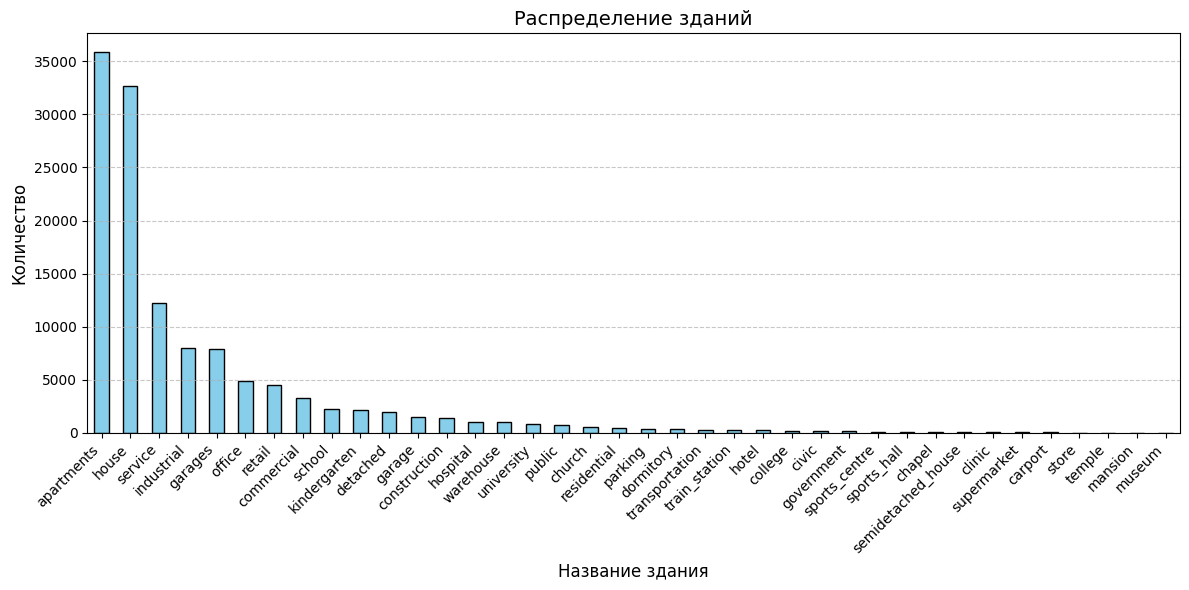

In [ ]:
# Считаем частоту категорий и фильтруем высокочастотные
counts = buildings["building"].value_counts()
counts = counts[counts >= 23].sort_values(ascending=False)
counts = counts.drop(["yes", "guardhouse", "kiosk", "shed", "terrace",
                      "hangar", "greenhouse", "bridge", "ruins", "gatehouse",
                      "toilets", "gazebo", "farm_auxiliary", "stable", "grandstand",
                      "hut", "cowshed", "bungalow", "ventilation_kiosk", "roof"])

# Создаем график
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Настройки оформления
plt.title('Распределение зданий', fontsize=14)
plt.xlabel('Название здания', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Я отфильтровал категории и оставил что-то более-менее частовстречающееся. При желании можно еще сильнее снизить размерность и оставить прям совсем частые (apartments, industrial, commercial etc.)

### **2.2. Разница слоя buildings vs. landuse**

Я всю жизнь прожил в Северном Тушино, поэтому взял его, чтобы проверить на адекватность данные OSM.

In [ ]:
# Посмотрим все адм.границы в датасете ЦФО
names_list = osm.get_boundaries()["name"].tolist()  # Преобразует столбец в список Python
print(names_list)

['Московская область', 'Калужская область', 'Москва', 'Северный административный округ', 'городской округ Мытищи', 'Пушкинский городской округ', 'городской округ Солнечногорск', 'муниципальный округ Чехов', 'городской округ Подольск', 'Ленинский городской округ', 'городской округ Красногорск', 'Одинцовский городской округ', 'городской округ Люберцы', 'городской округ Реутов', 'городской округ Балашиха', 'Наро-Фоминский городской округ', 'Западный административный округ', 'район Кунцево', 'район Крылатское', 'Мещанский район', 'район Сокольники', 'район Коммунарка', 'Филимонковский район', 'район Внуково', 'Жуковский район', 'район Хорошёво-Мнёвники', 'район Щукино', 'район Строгино', 'район Митино', 'район Куркино', 'район Кузьминки', 'Донской район', 'район Левобережный', 'район Ховрино', 'район Западное Дегунино', 'Тимирязевский район', 'район Коптево', 'Дмитровский район', 'район Северное Тушино', 'район Сокол', 'Савёловский район', 'район Отрадное', 'Молжаниновский район', 'район С

<Axes: >

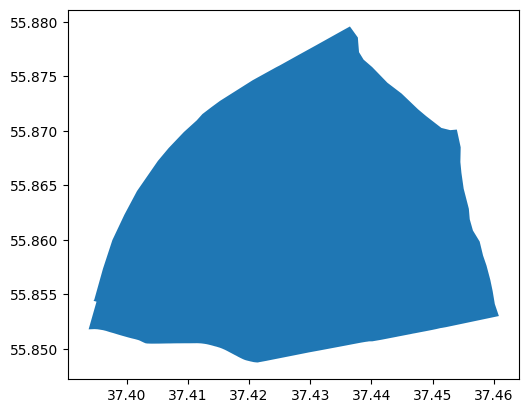

In [ ]:
# Получаем все административные границы
boundaries = osm.get_boundaries()

# Фильтруем мой район в Москве
bounding_box = boundaries[
    boundaries['name'].str.contains("район Северное Тушино", case=False, na=False)
]

# Визуализируем
bounding_box.plot()

In [ ]:
# возьмем границы Сев.Тушино
bbox_geom = bounding_box['geometry'].values[0]

# Инициализируем OSM по ним
osm_2 = OSM(fp, bounding_box=bbox_geom)

In [ ]:
# Достанем здания
hood = osm_2.get_buildings()

# Отфильтруем по высокочастотным категориям
hood = hood[hood["building"].isin(counts.reset_index()["building"])]

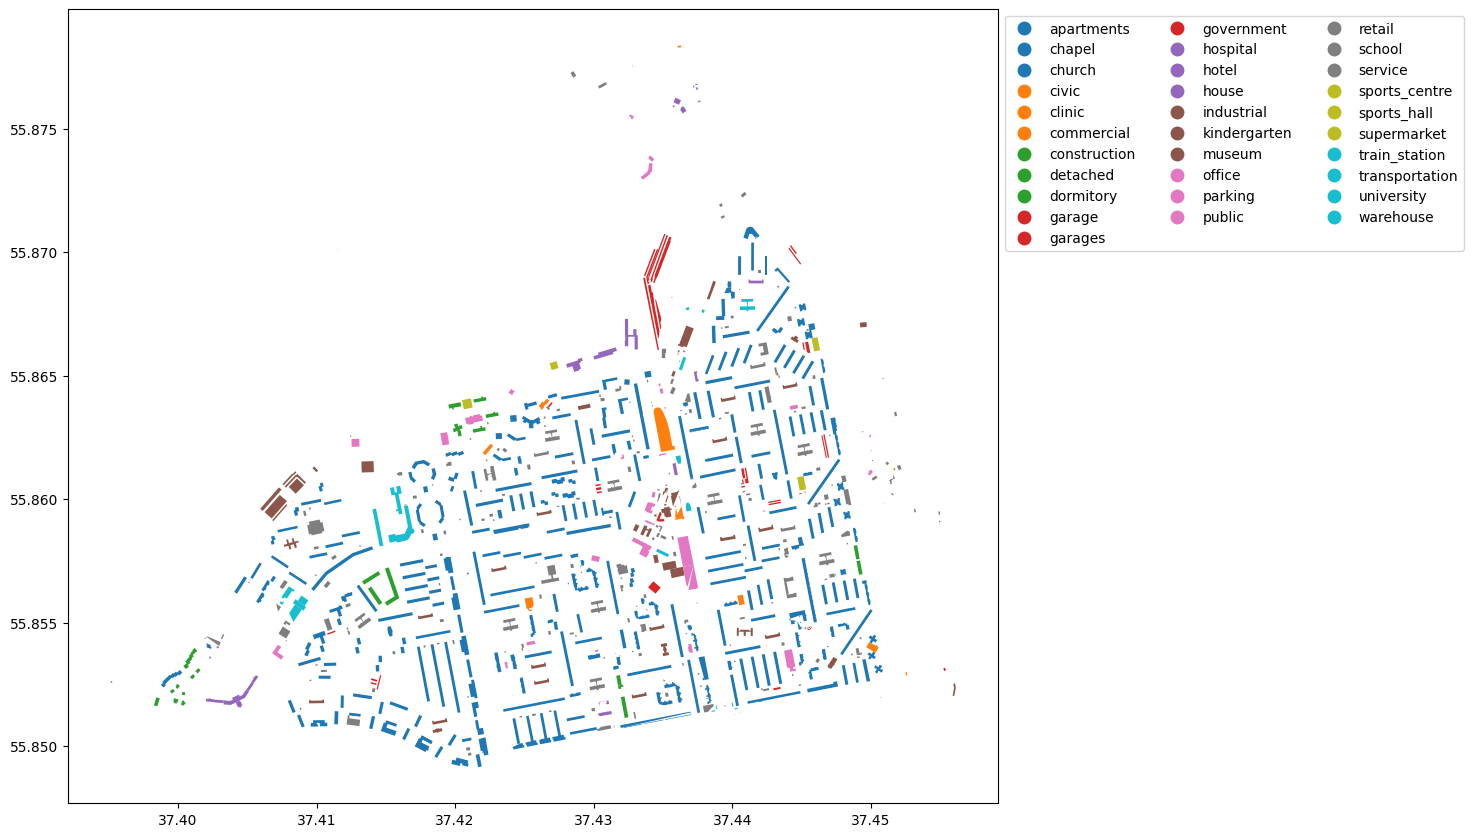

In [ ]:
# Визуализируем
ax = hood.plot(column="building", figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

В целом, данные на невооруженный взгляд более чем адекватны, Северное Тушино - спальный район, что видно по преимущественно синему цвету. Зданий с отсутствующей категорией не так много, что круто!

<Axes: >

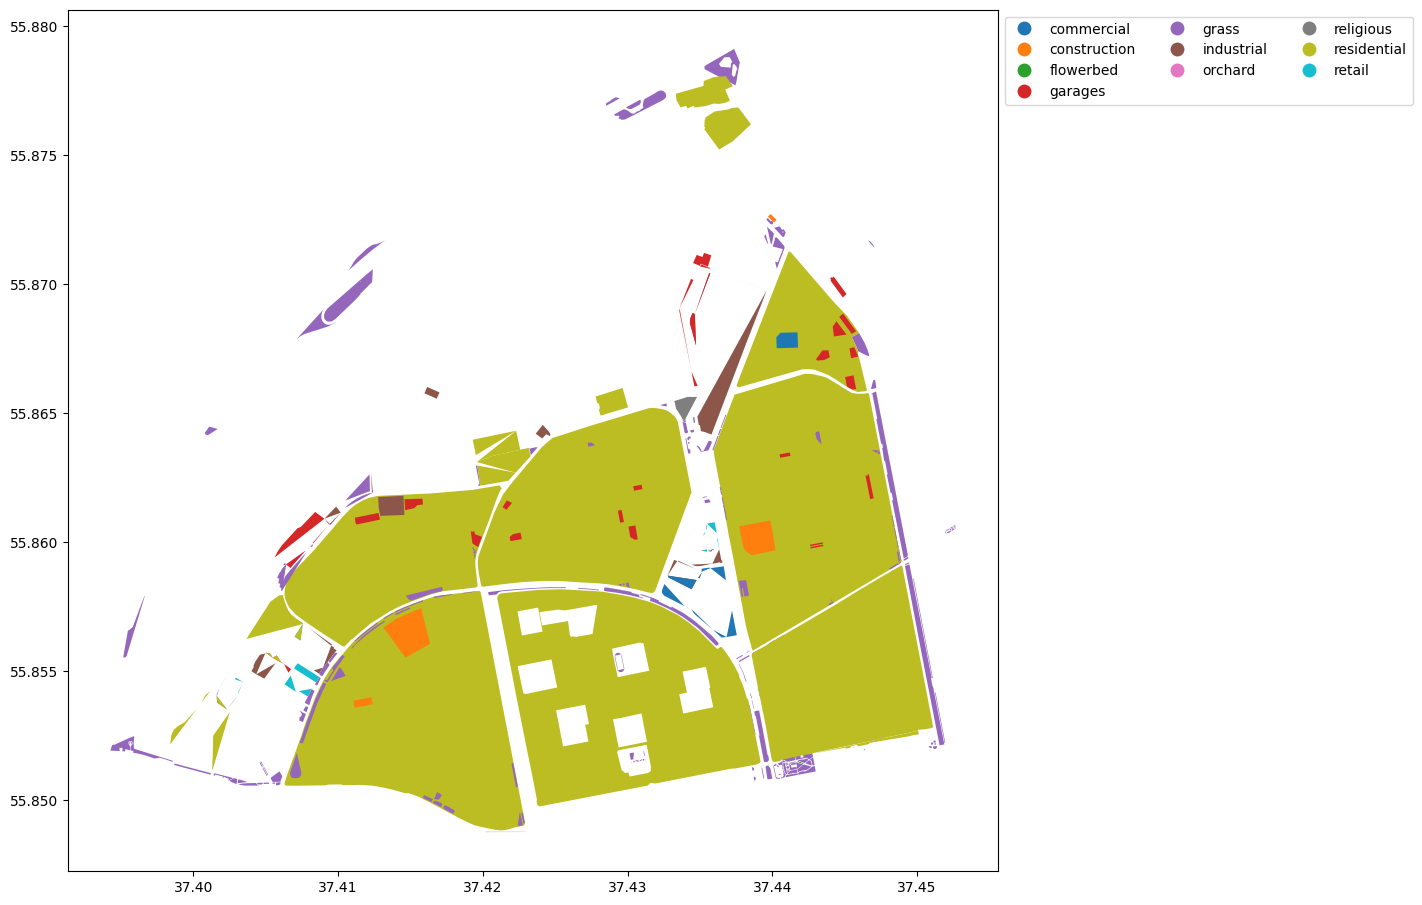

In [ ]:
# Визуализируем
landuse = osm_2.get_landuse()
landuse.plot(column='landuse', legend=True, figsize=(12,12), legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

Судя по одному району, выходит, что landuse - не очень хороший для использования слой (на микроуровне), поскольку по нему тяжело определить, что представляет из себя каждый кусочек карты

## **3. Точки интереса (POI)**

In [ ]:
# Укрупненная категория: все тэги в ней
CATEGORY_MAPPING = {
    "food_out": [
        "restaurant", "cafe", "fast_food", "bar", "pub", "ice_cream", "food_court",
        "bakery"
    ],
    "food_buy": [
        "supermarket", "butcher", "convenience", "greengrocer", "deli",
        "confectionery", "seafood", "cheese", "wine", "beverages", "alcohol"
    ],
    "education": [
        "school", "university", "college", "kindergarten", "childcare", "nursery",
        "library", "research_institute", "language_school", "music_school",
        "driving_school", "tutoring", "educational_institution"
    ],
    "transport": [
        "bus_station", "taxi", "bus_stop", "train_station", "subway_entrance"
    ],
    "health": [
        "hospital", "clinic", "pharmacy", "doctors", "dentist", "veterinary",
        "medical_center"
    ],
    "shopping": [
        "department_store", "mall", "clothes", "electronics", "boutique", "shoes", "fashion",
        "jewelry", "watches", "accessories", "variety_store", "second_hand", "thrift_store",
        "chemist", "cosmetics", "beauty", "medical_supply", "perfumery", "agrarian", "appliance",
        "electrical","florist", "hardware", "houseware", "furniture", "kitchen", "bed",
        "computer", "mobile_phone", "outdoor", "sports", "fishing", "hunting", "bicycle",
        "books", "stationery", "gift", "toy", "pet", "music", "anime",
        "laundry", "dry_cleaning", "e-cigarette", "pawnbroker",
        "wholesale", "telecommunication"
    ],
    "sports": [
        "fitness_center", "gym", "sports_center", "swimming_pool", "yoga", "dance",
        "stadium", "pitch", "golf_course", "bowling_alley", "ski_rental", "ice_rink",
        "marina", "water_park", "sauna", "horse_riding", "sports_hall", "tennis", "volleyball",
        "basketball", "skateboard", "surfing"
    ],
    "services": [
        "bank", "atm", "post_office",
        "coworking", "notary", "lawyer", "accountant", "surveyor", "architect",
        "computer_repair", "electrician", "locksmith", "tailor", "hvac","pet_grooming",
        "nail_salon", "massage", "hairdresser","barber"
    ],
    "religion": [
        "place_of_worship", "church", "mosque", "temple", "synagogue", "shrine", "cathedral",
        "chapel", "monastery"
    ],
    "leisure": [
        "community_center", "cultural_center","theatre", "cinema", "opera", "planetarium",
        "social_center", "museum", "gallery", "arts_centre", "theme_park", "amusement_arcade",
        "beach_resort"
    ],
    "nature": [
        "park", "garden", "forest", "nature_reserve", "beach"
    ]
}

In [ ]:
# Все тэги в ней: укрупненная категория
REVERSE_MAPPING = {}
for category, tags in CATEGORY_MAPPING.items():
    for tag in tags:
        REVERSE_MAPPING[tag] = category  # Теперь каждый тег ведёт прямо к категории

Я субъективно взял, пожалуй, самые важные тэги и придумал ряд укрупненных категорий, чтобы не перегружать алгоритм.

Как вы видите, я еще сделал что-то вроде invert крупная категория:тэг -> тэг:крупная категория, поскольку так быстрее все считается )

In [ ]:
# Достаёт значение тега из строки вида 'amenity=restaurant'
def extract_tag_value(osm_tag):
    if pd.isna(osm_tag):
        return None
    if '=' in osm_tag:
        return osm_tag.split('=')[1]  # берём часть после '='
    return osm_tag

# Тэг в укрупненную категорию
def map_poi_to_category(osm_tag):
    tag_value = extract_tag_value(osm_tag)
    if not tag_value:
        return "other"
    return REVERSE_MAPPING.get(tag_value, "other")  # O(1) поиск!

In [ ]:
# Там 3 тэга: amenity, shop, tourism
custom_filter = {'amenity': True, "shop": True}
pois = osm_2.get_pois(custom_filter=custom_filter) # GeoPandas DataFrame

# Собираем информацию по тэгам
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

In [ ]:
# Добавляем колонку 'category' на основе тегов
pois['category'] = pois['poi_type'].apply(map_poi_to_category)
pois = pois[pois["category"] != "other"]

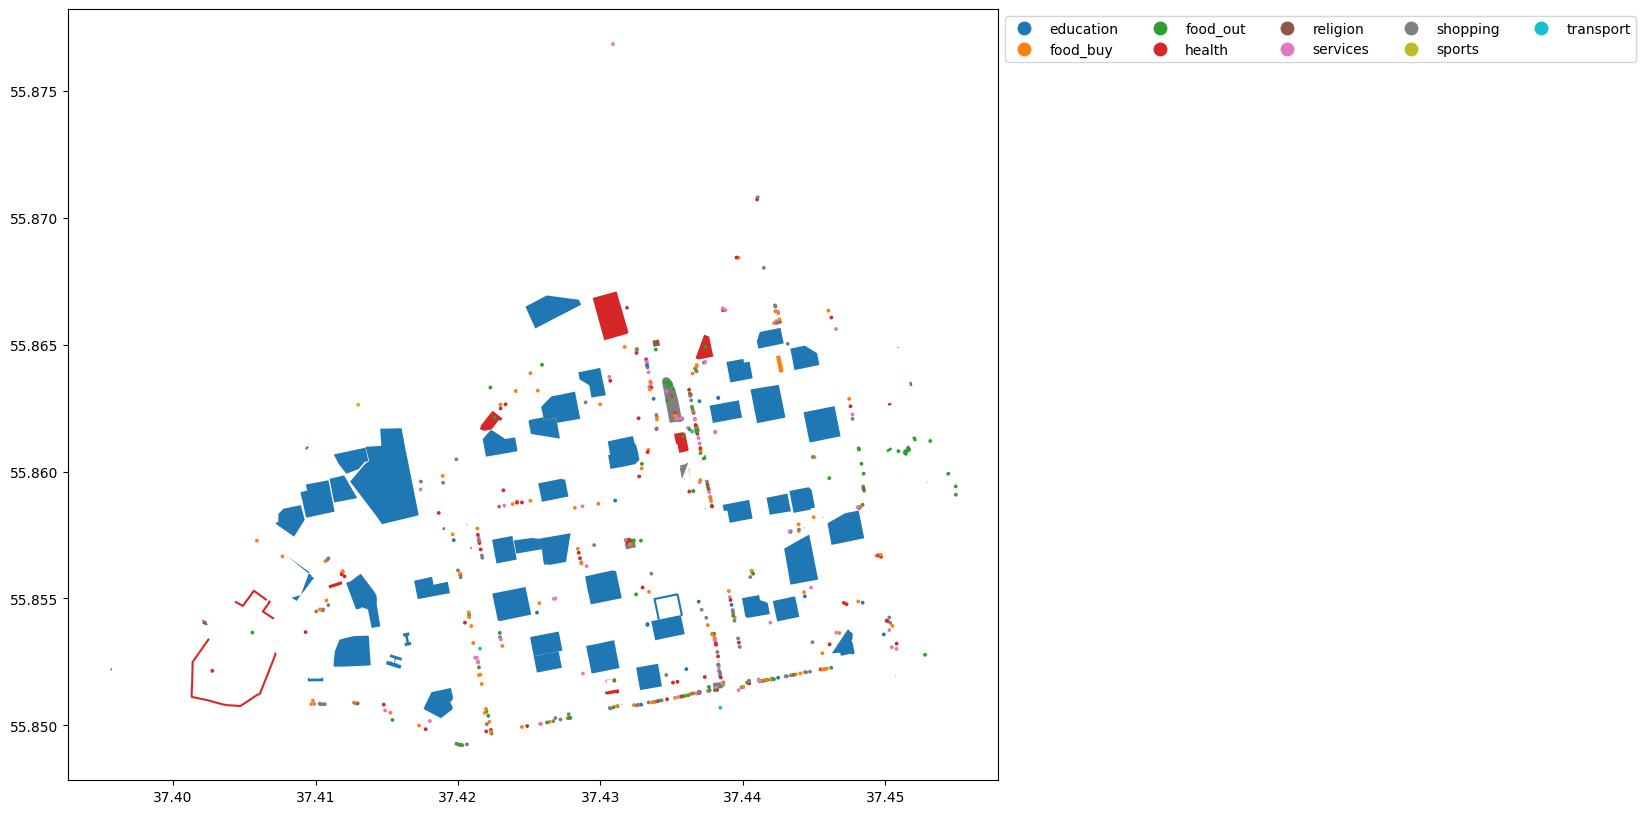

In [ ]:
# Визуализируем
ax = pois.plot(column='category', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

## **4. Промежуточный результаты**

Фактически парсер готов, его можно масштабировать:

- Менять города

- Изменять POI и Building, которые парсятся

- Нарезать карту на кусочки и в них посчитать кол-во объектов определенного класса